# New-York City juvenile crime rate VS. after-school activities

This notebook extends [Assaf Cohen's](https://www.kaggle.com/assafco) work ["NYC Crime vs Education - GEOvisualisation tutorial"](https://www.kaggle.com/assafco/nyc-crime-vs-education-geovisualisation-tutorial) by:
1. Further exploring the data.
2. Proposing a tool which recommends locations to open new after-school activities.

The notebook demonstrates the use of Folium maps and WordCloud visualization tool, as well as a sophisticated use of k-means algorithm.

### Datasets:
After school activities NYC - https://data.cityofnewyork.us/Education/DYCD-after-school-programs/mbd7-jfnc
<br>Arrest dataset of 2019 - https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc

### Imports and paths:

In [1]:
import pandas as pd
import numpy as np
import math
import re
from collections import Counter
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from sklearn.cluster import KMeans
from wordcloud import WordCloud
%matplotlib inline

In [2]:
ARREST_PATH = 'data/NYPD_Arrest_Data_Year_to_Date.csv'
EDUCATIONAL_PATH = 'data/DYCD_after-school_programs.csv'

### NYPD arrests dataset cleaning:

In [3]:
def felony_description_clean(desc):
    """Returns a clean string of input description."""
    
    # if input is np.nan
    if type(desc) is not str:
        return ''

    output = desc.lower()
    output = re.sub(r'[0-9]+|etc[.]*|unknown time|unknown|-misd.', '',output)
    output = re.sub(r'[,]+', ',',output)
    output = re.sub(r',[ ]*possession|,[ ]*possess.|,[ ]*possessi', ' possession',output)
    output = re.sub(r',[ ]*sale', ' sale',output)
    output = re.split(',|&', output)

    # replace 1st and 2nd if seperated by comma
    if len(output)>1:
        output.insert(0, output.pop(1))

    output = [word for word in output if not re.findall(r'unc',word)]
    output = ['robbery'] if 'robbery' in output else output
    output = ' '.join(output).strip().capitalize()
    output = output.replace('Ny','NY')
    output = re.sub(r'[ ]+', ' ',output)
    if output=='Obstr breath/circul':
        output = 'Obstruction of Breathing or Blood Circulation'
    if output == 'Endangering welfare child':
        output = 'Child welfare endangering'
        
    return output

In [4]:
def code_to_borough(code):
    """Maps a borough code to its corresponding borough name."""
    
    code_dict = {'B': 'Bronx', 'S': 'Staten Island', 'K': 'Brooklyn', 'M': 'Manhattan' , 'Q': 'Queens'}
    return code_dict[code]

In [5]:
# read CSV
arrest_df = pd.read_csv(ARREST_PATH, index_col=False)

In [6]:
# rename columns
arrest_df.rename(columns={"ARREST_BORO": "Borough", "PD_DESC": "Felony_description",  "AGE_GROUP": "Age_group"}, inplace = True)

# clean the data
arrest_df['Borough'] = arrest_df['Borough'].apply(code_to_borough)
arrest_df['Felony_description'] = arrest_df['Felony_description'].apply(felony_description_clean)

# leave only relevant columns
arrest_df= arrest_df[['Borough','Felony_description','Age_group', 'Latitude', 'Longitude']]

# drop cuplicates
arrest_df.drop_duplicates(inplace=True)

In [7]:
arrest_df.head()

,Borough,Felony_description,Age_group,Latitude,Longitude
0,Brooklyn,Assault,<18,40.680570,-73.983925
1,Queens,Burglary,25-44,40.693587,-73.902781
2,Brooklyn,Weapons possession,18-24,40.675770,-73.915162
3,Queens,Traffic,25-44,40.712596,-73.880699
4,Brooklyn,Petit from open areas larceny,45-64,40.703249,-73.944275


### NYPD arrests data exploration by WordCloud:

In [8]:
def wordcloud(df, column):
    """Creates and shows a wordcloud created of frequencies of values in input column."""
    
    # create frequncies of felony descriptions
    felonies_freq = Counter(df[column])

    # plot wordcloud
    wordcloud = WordCloud(width = 1200, height = 800, min_font_size = 14, colormap='Dark2', prefer_horizontal=0.85)
    wordcloud.generate_from_frequencies(frequencies=felonies_freq)
    plt.figure(figsize = (20, 18), facecolor = None) 
    plt.imshow(wordcloud)

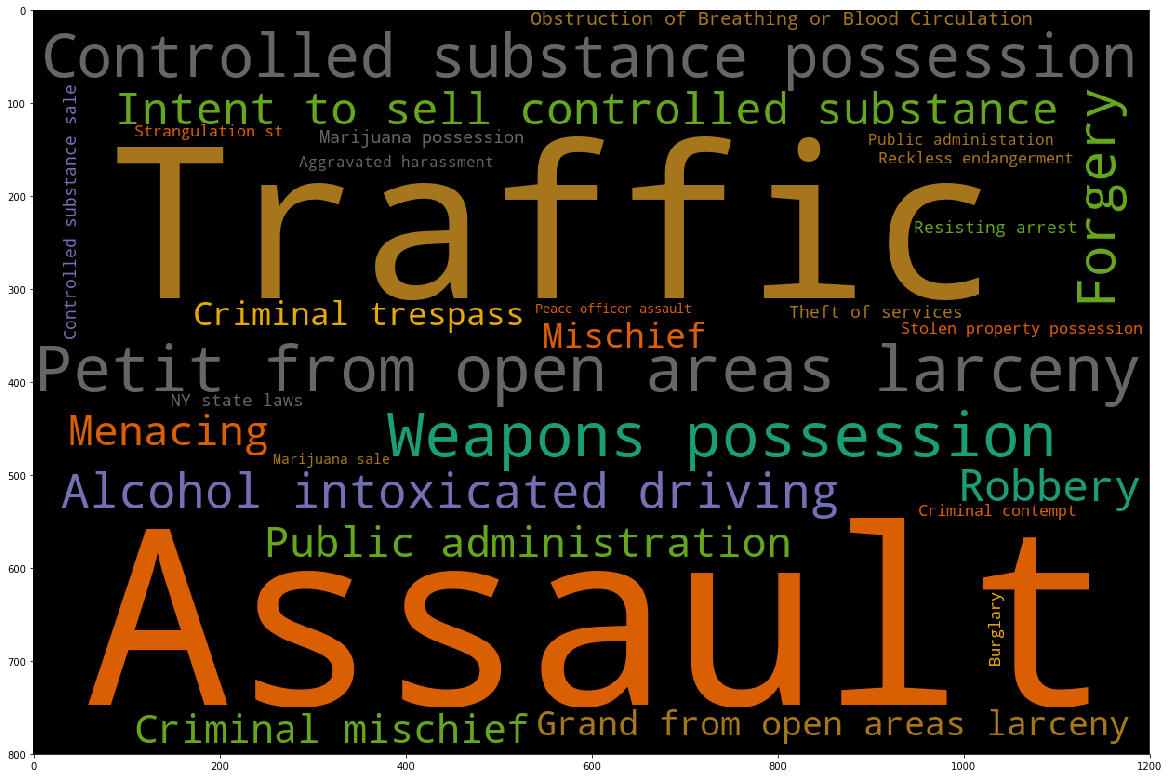

In [9]:
wordcloud(arrest_df, 'Felony_description')

We can cobserve the variety and frequencies of felonies commited in NYC year to date. <br>

### After-school activities dataset cleaning:

Most of the rows (except for 20) contain coordiantes values in column 'Location 1'.<br>
It turns out that in rows which also contain 'Latitude' and 'Longitude' values,<br>
they are more accurate than the coordinates values in 'Location 1' column, like someone has fixed them.<br>
In rows where there are no 'Latitude' and 'Longitude' values, the coordiantes values in 'Location 1' are pretty accurate.

In [10]:
def _address_clean(address):
    """Returns a clean address string."""
    
    # join adress to one string (if composed of a list whic was split beacues of '\n')
    address = ' '.join(address)
    
    # put whitespace between address and zip code
    address = f'{address[:-5]} {address[-5:]}'
    
    return address

In [11]:
def _coordianted_complete(coords, original_lat, original_lon):
    """Returns fixed Latitude and Longitude values."""
    
    # create latitude and longitude floats from coords string
    latitude_from_location, longitude_from_location = coords[1:-1].split(', ')
    latitude_from_location = float(latitude_from_location)
    longitude_from_location = float(longitude_from_location)
    
    # if latitude or longitude do not exist, populate them with coordinates extracted from 'Address_and_Coords' columns
    if np.isnan(original_lat) or np.isnan(original_lon):
        return latitude_from_location, longitude_from_location
        
    else:
        return original_lat, original_lon

In [12]:
def address_and_coords_fix(df):
    """Returns lists of fixed addresses, latitudes and longitudes."""

    addresses, latitudes, longitudes = [], [], []

    for tup in df.itertuples():

        # split 'Address_and_Coords' values to address (might be composed of several rows) and to coordinated tuple (string)
        *address, coords = tup.Address_and_Coords.split('\n')
        
        # clean address and add to list
        addresses.append(_address_clean(address))
        
        # complete coordiantes and add to lists
        latitude, longitude = _coordianted_complete(coords, tup.Latitude, tup.Longitude)
        latitudes.append(latitude)
        longitudes.append(longitude)
        
    return addresses, latitudes, longitudes

In [13]:
# read CSV
edu_df = pd.read_csv(EDUCATIONAL_PATH)

In [14]:
# rename columns
columns_rename_map = {
    "BOROUGH / COMMUNITY": "Borough", "PROGRAM TYPE": "Program_type",
    "PROGRAM": "Program", "SITE NAME": "Site_name", "Location 1": 'Address_and_Coords'
}
edu_df.rename(columns=columns_rename_map, inplace = True)

# drop duplicates and NaNs
edu_df.dropna(subset=['Address_and_Coords'], inplace=True)

# filter only New-York city boroughs
edu_df = edu_df[edu_df['Borough'].isin(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'])]

# remove unnecessary columns
edu_df = edu_df[['Program_type', 'Program', 'Site_name', 'Borough', 'Address_and_Coords', 'Latitude', 'Longitude']]

# fix address and coordinates
addresses, latitudes, longitudes = address_and_coords_fix(edu_df)

edu_df['Address'] = addresses
edu_df['Latitude'] = latitudes
edu_df['Longitude'] = longitudes

# drop duplicates (data contain a lost of duplicates, with different names)
edu_df.drop_duplicates(subset = ['Latitude','Longitude'], inplace=True)

# drop 'Address_and_Coords' column, and change columns order
edu_df= edu_df[['Program_type', 'Program', 'Site_name', 'Borough', 'Address', 'Latitude', 'Longitude']]

In [15]:
edu_df.head()

,Program_type,Program,Site_name,Borough,Address,Latitude,Longitude
7,"Family Support,NDA Programs",Fatherhood Initiative,Nursing Family Partnership,Bronx,489 491 East 153 Street 10454,40.805847,-73.916285
21,After-School Programs,Beacon,PS 8,Bronx,3710 Briggs Street 10467,40.877048,-73.871533
22,After-School Programs,Beacon,IS 192,Bronx,650 Hollywood Avenue 10465,40.826526,-73.818417
23,After-School Programs,Beacon,MS 201,Bronx,730 Bryant Avenue 10474,40.815477,-73.885770
24,After-School Programs,Beacon,MS 142,Bronx,3750 Baychester Avenue 10466,40.884953,-73.840524


### Juvenile crime rate VS.  after-school activities visualization:

To extract juvenile crimes, we will only consider crimes of <18 age group.<br>
The crimes are represented by a Heatmap.<br>
The after-school activities are represented by circles with radius of 750 meters, in order to investigate whether the distance from such an activity influences juvenile crime rate.

In [16]:
# create a list of children (<18 Age_group) crime location-tuples
arrest_18_df = arrest_df[(arrest_df['Age_group']=='<18')]
arrest_18_locations = list(zip(arrest_18_df['Latitude'],arrest_18_df['Longitude']))

# create a list of after-scholl activity location-tuples
edu_positions = list(zip(edu_df['Latitude'],edu_df['Longitude']))  # create a list of locations (tuples)

# create folium map centerd on the average location of crimes
fol = folium.Map(np.mean(arrest_18_locations, axis=0), zoom_start=10, tiles = 'Stamen Terrain')  

# create Heatmap of crime locations
HeatMap(arrest_18_locations, radius = 13).add_to(fol)

# add circles to denote after-school activity locations
[folium.Circle(pos, radius=750, color='black', fill=True, fill_opacity = 0.01, weight=0.4).add_to(fol) for pos in edu_positions]

fol

We can observe that some of the high juvenile crime rates areas (such as in Manhattan) does not have enough access to after-school activities.<br>
We can observe that other districts do have more dense after-school activities coverage areas but still have a sginificant crime rate (such as the Bronx).

#### From the examined data, one can not argue for a strong correlation between after-school activities' locations and juvenile crime rate! <br>

Maybe more data could help get to this conclusion.<br>
For example, if we had historical data of after-school activities, we might be able to make temporal connections between activities existance and the change in juvenile crime rate over time.

### Recommendation tool - where to open new after-school activities:

As we observed above, some of the high crime rates areas does not have enough access to after-school activities.<br>
We believe it is important to at least supply access, and to enable the children the chance to attend after-school activities in these shortage areas.<br><br>
The following section will demonstate a tool which could recommend NYC decision makers where to open an after-school activity in poor-covarge areas.



#### The tool - edu_recommend() function operates as following, using the other utiliy fucntions:

1. Creates a list of crime locations, and after-school activity locations, within a given borough.
2. Creates a list of all crime locations within efficiency range of some (at least one) after-school activity.
3. Creates a list of all crime locations which are out of efficiency range of any (not even one) after-school activity.
4. Using heuristic_kmeans(), as follows:<br>
    a. For each integer in the range [num. recommendations, num. recommendations+10] we compute KMeans clusters.<br>
    b. For each of the clusters' options, we compute the amount of out-of-range arrests which became in-range, and choose the maximal option.<br>
    c. From that maximal option, we again choose the num. recommendations clusters which cover the most out-of-range arrests.
5. plotting the map.


The 3 main arguments of edu_recommend() function are:<br>
1. borough - Which borough to get recommendation about.
2. max_range - What is the maximum effctive range of an activity (according to the decision makers additional data such as: popolution density, demogrphic breakdown, crime rate, and other factors).
3. num_rec - Number of location to recommend (based on budgets, etc.).

The tool works each time only on one borough for 2 main reasons:
- Folium map has hard time showing more than 2500 markers on one map.<br>
The solution of using cluster markers does not serve well the visualization of our problem.

- Enabling more granularity.<br>
E.g. one can decide how much to invest and how many new after-school activites to open, indepently for each borough.

In [17]:
def _corrected_distance(point_1, point_2, lat_corr=111.32, lon_corr=84.288):
    """
    Returns the corrected distance between 2 location (location-tuples).

    Folium uses Geographic Decimal degrees coordinate system.
    As we go farther from the equator, geographic coordinate system requires a different correction.
    The approximated corrections of measured distance in Latitude and Longitude
    in New-York city are 111.32 and 84.288 respectively.
    """

    lat_dist = (point_1[0] - point_2[0]) * lat_corr
    lon_dist = (point_1[1] - point_2[1]) * lon_corr
    return math.sqrt(lat_dist ** 2 + lon_dist ** 2)

In [18]:
def _in_edu_range(edu_locations, crime_locations, efficiency_range):
    """Returns a list of crime locations which are within efficiency range of at least one after-school activity location."""
    in_range_crimes = []

    for crime_location in crime_locations:
        in_range = False

        # check if crime_location is within efficiency_range of any edu-location
        for edu_location in edu_locations:
            if _corrected_distance(crime_location, edu_location) < efficiency_range:
                in_range = True
                break

        # if found, append to in_range_crimes list
        if in_range:
            in_range_crimes.append(crime_location)

    return in_range_crimes

In [19]:
def _borough_locations(ed_df, arr_df, borough):
    """Returns lists of all after-school activities' locations and crime locations within borough."""

    temp_edu = ed_df[ed_df['Borough'] == borough]
    edu_locs = list(zip(temp_edu['Latitude'], temp_edu['Longitude']))

    temp_arr = arr_df[arr_df['Borough'] == borough]
    arrest_locs = list(zip(temp_arr['Latitude'], temp_arr['Longitude']))

    return edu_locs, arrest_locs

In [20]:
def _heuristic_kmeans(crime_locations, efficiency_range, num_clusters, max_opt_groups):
    """
    Returns a list of after-school activity locations recommendations.

    Performs multiple K-Means clustering ,in a heuristic manner, as described above.
    Number of locations is determined by num_clusters.
    """
    
    new_edu_options = []

    for num in range(num_clusters, max_opt_groups):

        # create and fit k-means model with num clusters
        model = KMeans(n_clusters=num)
        model.fit(crime_locations)

        # a list of number of arrests which where out-of-range and now are in-range
        new_in_range = [len(_in_edu_range([loc], crime_locations, efficiency_range)) for loc in model.cluster_centers_]

        # append education locations, along with number of corresponding in-range crime locations
        new_edu_options.append((model.cluster_centers_, new_in_range, sum(new_in_range)))

    # extract maximum benefit group of generated locations
    max_benefit = max(new_edu_options, key=lambda x: x[2])

    # extract num_clusters-max-crimes new education locations
    new_edu = max_benefit[0][np.argsort(max_benefit[1])[-num_clusters:]]
    new_edu_scores = np.array(max_benefit[1])[np.argsort(max_benefit[1])[-num_clusters:]]

    # return the locations which yielded maximal in-range crime locations
    return new_edu, new_edu_scores

In [21]:
def _pop_string(dic):
    """Creates the string for folium popups."""
    
    lat = str(dic['loc'][0])[:6]
    lon = str(dic['loc'][1])[1:7]
    return f'Location:\nN{lat}/W{lon}\nScore: {dic["score"]}'

In [22]:
def _summary(comp_loc, edu_loc, borough, in_rng, out_rng, max_rng, rec_edu_loc, num_rec):
    """Pretty printing."""

    new_in_range = len(_in_edu_range(rec_edu_loc, out_rng, max_rng))
    output = f'{len(comp_loc)} <18 children crimes are recorded year to date in {borough}.\n'
    output += f'{len(edu_loc)} after-school programs are taking place in {borough}.\n'
    output += f'{len(in_rng)} of the crimes are committed within {max_rng} km of some program location.\n'
    output += f'{len(out_rng)} of the crimes are farther than {max_rng} km of any program location.\n'
    output += f'The new {num_rec} recommended location will bring {new_in_range} crimes into {max_rng} km range.'
    return output

In [23]:
def _create_map(arrest_locations, in_range_crimes, out_range_crimes, rec_edu_locations, rec_edu_scores, max_range):
    """
    Return a folium map with marked out-of-range crimes, in-range crimes and circles denoting reccomendations
    of new after-school activities' locations.
    """
    
    # create folium map centerd on the average location of crimes
    map_center_location = np.array(arrest_locations).mean(axis=0)
    ny_map = folium.Map(location=map_center_location, zoom_start=11,control_scale=True, tiles = 'Stamen Terrain')
    
    # add red markers to denote out-of-range crimes
    [folium.CircleMarker(pos, radius=1, color='red', fill=True, weight=1).add_to(ny_map) for pos in out_range_crimes]
    
    # add green markers to denote in-range crimes
    [folium.CircleMarker(pos, radius=0.8, color='green', fill=True, weight=0.8).add_to(ny_map) for pos in in_range_crimes]
    
    # create popup proporties for edu-locations
    pop_dict = {i: {'loc': loc, 'score': score} for i, (loc, score) in enumerate(zip(rec_edu_locations, rec_edu_scores))}
    
    # add circles to denote the recommendations, and their efficiency range
    [folium.Circle(
        pos, radius=max_range*1000, color='black', fill=True, weight=0.7,
        popup=_pop_string(pop_dict[i])).add_to(ny_map)
     for i, pos in enumerate(rec_edu_locations)]
    
    return ny_map

In [24]:
def edu_recommend(borough, max_range, num_rec, ed_df, arr_df, max_opt_groups=None):
    
    # create locations' lists of after-school activities and arrests
    edu_locations, arrest_locations = _borough_locations(edu_df, arr_df, borough)
    
    # a list of all arrest locations in range of some after-school activity
    in_range_crimes = _in_edu_range(edu_locations, arrest_locations, max_range)
    
    # a list of all arrest locations out of range of any after-school activity.
    out_range_crimes = [cr for cr in arrest_locations if cr not in in_range_crimes]
    
    max_opt_groups = max_opt_groups if max_opt_groups else num_rec + 10
    
    # find best locations to cover out of range arrests
    rec_edu_locations, rec_edu_scores = _heuristic_kmeans(out_range_crimes, max_range, num_rec, max_opt_groups)
    
    # create folium map
    ny_map = _create_map(arrest_locations, in_range_crimes, out_range_crimes, rec_edu_locations, rec_edu_scores, max_range)
    
    #Summary string generation
    summ = _summary(arrest_locations, edu_locations, borough,
                   in_range_crimes, out_range_crimes, max_range, rec_edu_locations, num_rec)
    
    return ny_map, rec_edu_locations, rec_edu_scores, summ

In [25]:
def location_print(rec_loc, rec_loc_scores):
    """Pretty printing."""

    print('Ranked list of recommended locations (ranked by amount of new covered crimes):')
    for rec, score in reversed(list(zip(rec_loc, rec_loc_scores))):
        lat = str(rec[0])[:6]
        lon = str(rec[1])[1:7]
        print(f'Location N {lat} / W {lon} will bring {score} crimes into an after-school activity efficency range.')

**Example 1** - Brooklyn, effective range = 0.7 km, 7 recommendations:

In [26]:
borough = 'Brooklyn'  # choose from 'Bronx', 'Manhattan', 'Brooklyn', 'Queens', or 'Staten Island'.
ny_map, rec_edu_locations, rec_edu_scores, summ = edu_recommend(borough, 0.7, 7, edu_df, arrest_18_df)

In [27]:
ny_map

Green markers denote crimes commited within the given maximal range from some program location.<br>
Red markers denote crimes commited farther than the maximal range of any program location.<br>
Black circles denote maximal range radius of the recomendations for setting up new after-school activities.

Pressing on the black circles will popup the location, and the number of crimes it will cover.

In [28]:
print(summ)

1002 <18 children crimes are recorded year to date in Brooklyn.
331 after-school programs are taking place in Brooklyn.
966 of the crimes are committed within 0.7 km of some program location.
36 of the crimes are farther than 0.7 km of any program location.
The new 7 recommended location will bring 24 crimes into 0.7 km range.


In [29]:
location_print(rec_edu_locations, rec_edu_scores)

Ranked list of recommended locations (ranked by amount of new covered crimes):
Location N 40.647 / W 73.906 will bring 7 crimes into an after-school activity efficency range.
Location N 40.643 / W 73.933 will bring 5 crimes into an after-school activity efficency range.
Location N 40.630 / W 73.929 will bring 3 crimes into an after-school activity efficency range.
Location N 40.610 / W 73.921 will bring 3 crimes into an after-school activity efficency range.
Location N 40.639 / W 73.920 will bring 2 crimes into an after-school activity efficency range.
Location N 40.615 / W 73.975 will bring 2 crimes into an after-school activity efficency range.
Location N 40.655 / W 73.867 will bring 2 crimes into an after-school activity efficency range.


One thing worth to mention:<br>
For some reason, a lot of arrests are recorded at the exact same location. These aressts appear as 1 marker on the maps, thus hurt the visualization.<br>
That is the reason why the added crimes to the effective range, are more than it looks on the maps.<br>
For example, at location (40.671107, -73.881433) 2 arrests occured:

In [30]:
arrest_18_df[(arrest_18_df['Longitude'] == -73.88143295699997) & (arrest_18_df['Latitude'] == 40.67110691100004)]

,Borough,Felony_description,Age_group,Latitude,Longitude
48947,Brooklyn,Rape,<18,40.671107,-73.881433
62356,Brooklyn,Sexual abuse,<18,40.671107,-73.881433


**Example 2** - Manhattan, effective range = 0.5 km, 14 recommendations:

In [31]:
borough = 'Manhattan' # choose from 'Bronx', 'Manhattan', 'Brooklyn', 'Queens', or 'Staten Island'.
ny_map, rec_edu_locations, rec_edu_scores, summ = edu_recommend(borough, 0.5, 14, edu_df, arrest_18_df)

In [32]:
ny_map

Green markers denote crimes commited within the given maximal range from some program location.<br>
Red markers denote crimes commited farther than the maximal range of any program location.<br>
Black circles denote maximal range radius of the recomendations for setting up new after-school activities.

Pressing on the black circles will popup the location, and the number of crimes it will cover.

In [33]:
print(summ)

801 <18 children crimes are recorded year to date in Manhattan.
156 after-school programs are taking place in Manhattan.
715 of the crimes are committed within 0.5 km of some program location.
86 of the crimes are farther than 0.5 km of any program location.
The new 14 recommended location will bring 73 crimes into 0.5 km range.


In [34]:
location_print(rec_edu_locations, rec_edu_scores)

Ranked list of recommended locations (ranked by amount of new covered crimes):
Location N 40.763 / W 73.966 will bring 15 crimes into an after-school activity efficency range.
Location N 40.775 / W 73.955 will bring 14 crimes into an after-school activity efficency range.
Location N 40.767 / W 73.963 will bring 12 crimes into an after-school activity efficency range.
Location N 40.734 / W 74.005 will bring 10 crimes into an after-school activity efficency range.
Location N 40.767 / W 73.958 will bring 10 crimes into an after-school activity efficency range.
Location N 40.763 / W 73.972 will bring 9 crimes into an after-school activity efficency range.
Location N 40.758 / W 73.977 will bring 8 crimes into an after-school activity efficency range.
Location N 40.761 / W 73.981 will bring 6 crimes into an after-school activity efficency range.
Location N 40.752 / W 73.977 will bring 4 crimes into an after-school activity efficency range.
Location N 40.778 / W 73.982 will bring 3 crimes int